In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'1gV3lTGPAL-x0c-EqZXyF4saHo7AVLN4j'})
file_import.GetContentFile('AttentionWithContext.py') 

from AttentionWithContext import AttentionWithContext

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    return one_by_one

In [10]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

features = one_by_one(filtersNumber, embedding_dropout)
features = AttentionWithContext()(features)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________

In [11]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42848/102124 [===========>..................] - ETA: 57s - loss: 0.1409 - acc: 0.9488

102124/102124 [==============================] - 102s 997us/step - loss: 0.1021 - acc: 0.9638 - val_loss: 0.2211 - val_acc: 0.9681
Epoch 2/32
  5600/102124 [>.............................] - ETA: 1:28 - loss: 0.0636 - acc: 0.9773

102080/102124 [============================>.] - ETA: 0s - loss: 0.0653 - acc: 0.9770

102124/102124 [==============================] - 100s 976us/step - loss: 0.0652 - acc: 0.9770 - val_loss: 0.0875 - val_acc: 0.9722
roc-auc: 0.9752 - roc-auc_val: 0.9712                                                                                                    
Epoch 3/32
 17312/102124 [====>.........................] - ETA: 1:17 - loss: 0.0593 - acc: 0.9788

102112/102124 [============================>.] - ETA: 0s - loss: 0.0591 - acc: 0.9789

102124/102124 [==============================] - 100s 977us/step - loss: 0.0591 - acc: 0.9789 - val_loss: 0.0802 - val_acc: 0.9714
Epoch 4/32
 27808/102124 [=======>......................] - ETA: 1:07 - loss: 0.0563 - acc: 0.9797

102112/102124 [============================>.] - ETA: 0s - loss: 0.0558 - acc: 0.9796

102124/102124 [==============================] - 99s 974us/step - loss: 0.0558 - acc: 0.9796 - val_loss: 0.0585 - val_acc: 0.9801
roc-auc: 0.9817 - roc-auc_val: 0.9786                                                                                                    
Epoch 5/32
 17376/102124 [====>.........................] - ETA: 1:17 - loss: 0.0542 - acc: 0.9802

102112/102124 [============================>.] - ETA: 0s - loss: 0.0542 - acc: 0.9799

102124/102124 [==============================] - 100s 977us/step - loss: 0.0542 - acc: 0.9799 - val_loss: 0.0604 - val_acc: 0.9775
Epoch 6/32
 27744/102124 [=======>......................] - ETA: 1:08 - loss: 0.0527 - acc: 0.9799

102112/102124 [============================>.] - ETA: 0s - loss: 0.0522 - acc: 0.9806

102124/102124 [==============================] - 99s 974us/step - loss: 0.0522 - acc: 0.9806 - val_loss: 0.0542 - val_acc: 0.9790
roc-auc: 0.9844 - roc-auc_val: 0.9812                                                                                                    
Epoch 7/32
 17376/102124 [====>.........................] - ETA: 1:16 - loss: 0.0508 - acc: 0.9812

102112/102124 [============================>.] - ETA: 0s - loss: 0.0514 - acc: 0.9809

102124/102124 [==============================] - 99s 974us/step - loss: 0.0514 - acc: 0.9809 - val_loss: 0.0569 - val_acc: 0.9801
Epoch 8/32
 27936/102124 [=======>......................] - ETA: 1:07 - loss: 0.0507 - acc: 0.9807

102124/102124 [==============================] - 99s 967us/step - loss: 0.0502 - acc: 0.9812 - val_loss: 0.0554 - val_acc: 0.9797



Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00024148408556357026.
roc-auc: 0.9858 - roc-auc_val: 0.9826                                                                                                    
Epoch 9/32
 20064/102124 [====>.........................] - ETA: 1:13 - loss: 0.0505 - acc: 0.9809

102112/102124 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9814

102124/102124 [==============================] - 99s 968us/step - loss: 0.0496 - acc: 0.9814 - val_loss: 0.0573 - val_acc: 0.9791
Epoch 10/32
 27808/102124 [=======>......................] - ETA: 1:07 - loss: 0.0489 - acc: 0.9817

102112/102124 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9815

102124/102124 [==============================] - 99s 967us/step - loss: 0.0491 - acc: 0.9816 - val_loss: 0.0575 - val_acc: 0.9784
roc-auc: 0.9853 - roc-auc_val: 0.9824                                                                                                    
Epoch 11/32
 17312/102124 [====>.........................] - ETA: 1:16 - loss: 0.0503 - acc: 0.9815

102112/102124 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9815

102124/102124 [==============================] - 99s 967us/step - loss: 0.0489 - acc: 0.9815 - val_loss: 0.0551 - val_acc: 0.9791
Epoch 12/32
 27808/102124 [=======>......................] - ETA: 1:07 - loss: 0.0487 - acc: 0.9813

102112/102124 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9818

102124/102124 [==============================] - 99s 972us/step - loss: 0.0481 - acc: 0.9818 - val_loss: 0.0512 - val_acc: 0.9810
roc-auc: 0.9878 - roc-auc_val: 0.9848                                                                                                    
Epoch 13/32
 17312/102124 [====>.........................] - ETA: 1:16 - loss: 0.0472 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9820

102124/102124 [==============================] - 98s 964us/step - loss: 0.0479 - acc: 0.9820 - val_loss: 0.0525 - val_acc: 0.9806
Epoch 14/32
 27808/102124 [=======>......................] - ETA: 1:07 - loss: 0.0475 - acc: 0.9817

102112/102124 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9821

102124/102124 [==============================] - 98s 961us/step - loss: 0.0474 - acc: 0.9821 - val_loss: 0.0542 - val_acc: 0.9795
roc-auc: 0.988 - roc-auc_val: 0.9848                                                                                                    
Epoch 15/32
 17376/102124 [====>.........................] - ETA: 1:16 - loss: 0.0477 - acc: 0.9819

102112/102124 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9821

102124/102124 [==============================] - 98s 960us/step - loss: 0.0470 - acc: 0.9821 - val_loss: 0.0537 - val_acc: 0.9804
Epoch 16/32
 27808/102124 [=======>......................] - ETA: 1:07 - loss: 0.0466 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9822

102124/102124 [==============================] - 99s 966us/step - loss: 0.0470 - acc: 0.9822 - val_loss: 0.0506 - val_acc: 0.9809
roc-auc: 0.988 - roc-auc_val: 0.9851                                                                                                    
Epoch 17/32
 17376/102124 [====>.........................] - ETA: 1:16 - loss: 0.0484 - acc: 0.9816

102112/102124 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9822

102124/102124 [==============================] - 98s 962us/step - loss: 0.0467 - acc: 0.9822 - val_loss: 0.0519 - val_acc: 0.9810
Epoch 18/32
 27744/102124 [=======>......................] - ETA: 1:07 - loss: 0.0460 - acc: 0.9826

102112/102124 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9822

102124/102124 [==============================] - 98s 964us/step - loss: 0.0466 - acc: 0.9822 - val_loss: 0.0519 - val_acc: 0.9805
roc-auc: 0.9875 - roc-auc_val: 0.9845                                                                                                    
Epoch 19/32
 17312/102124 [====>.........................] - ETA: 1:16 - loss: 0.0462 - acc: 0.9828

102112/102124 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9823

102124/102124 [==============================] - 98s 963us/step - loss: 0.0462 - acc: 0.9824 - val_loss: 0.0530 - val_acc: 0.9801

Epoch 00019: ReduceLROnPlateau reducing learning rate to 7.694652595091611e-05.
Epoch 20/32
 20512/102124 [=====>........................] - ETA: 1:14 - loss: 0.0474 - acc: 0.9820

102112/102124 [============================>.] - ETA: 0s - loss: 0.0463 - acc: 0.9824

102124/102124 [==============================] - 98s 962us/step - loss: 0.0463 - acc: 0.9824 - val_loss: 0.0509 - val_acc: 0.9807
roc-auc: 0.9886 - roc-auc_val: 0.9854                                                                                                    
Epoch 21/32
 17312/102124 [====>.........................] - ETA: 1:16 - loss: 0.0465 - acc: 0.9820

102112/102124 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9824

102124/102124 [==============================] - 98s 962us/step - loss: 0.0459 - acc: 0.9824 - val_loss: 0.0497 - val_acc: 0.9815
Epoch 22/32
 27808/102124 [=======>......................] - ETA: 1:06 - loss: 0.0448 - acc: 0.9828

102112/102124 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9825

102124/102124 [==============================] - 99s 965us/step - loss: 0.0460 - acc: 0.9825 - val_loss: 0.0504 - val_acc: 0.9812
roc-auc: 0.9878 - roc-auc_val: 0.9847                                                                                                    
Epoch 23/32
 17312/102124 [====>.........................] - ETA: 1:16 - loss: 0.0455 - acc: 0.9822

102112/102124 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9825

102124/102124 [==============================] - 98s 959us/step - loss: 0.0457 - acc: 0.9825 - val_loss: 0.0490 - val_acc: 0.9816
Epoch 24/32
 27808/102124 [=======>......................] - ETA: 1:06 - loss: 0.0459 - acc: 0.9825

102112/102124 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9824

102124/102124 [==============================] - 98s 956us/step - loss: 0.0458 - acc: 0.9824 - val_loss: 0.0539 - val_acc: 0.9794
roc-auc: 0.9879 - roc-auc_val: 0.9842                                                                                                    
Epoch 25/32
 17312/102124 [====>.........................] - ETA: 1:15 - loss: 0.0459 - acc: 0.9825

102112/102124 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9826

102124/102124 [==============================] - 98s 959us/step - loss: 0.0456 - acc: 0.9826 - val_loss: 0.0501 - val_acc: 0.9812
Epoch 26/32
 27808/102124 [=======>......................] - ETA: 1:05 - loss: 0.0435 - acc: 0.9833

102124/102124 [==============================] - 97s 954us/step - loss: 0.0454 - acc: 0.9827 - val_loss: 0.0489 - val_acc: 0.9818


roc-auc: 0.9889 - roc-auc_val: 0.9853                                                                                                    
Epoch 27/32
 26848/102124 [======>.......................] - ETA: 1:07 - loss: 0.0460 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9827

102124/102124 [==============================] - 99s 967us/step - loss: 0.0456 - acc: 0.9827 - val_loss: 0.0488 - val_acc: 0.9816
Epoch 28/32
 27808/102124 [=======>......................] - ETA: 1:06 - loss: 0.0440 - acc: 0.9833

102112/102124 [============================>.] - ETA: 0s - loss: 0.0452 - acc: 0.9828

102124/102124 [==============================] - 98s 962us/step - loss: 0.0452 - acc: 0.9828 - val_loss: 0.0483 - val_acc: 0.9816
roc-auc: 0.9891 - roc-auc_val: 0.9861                                                                                                    
Epoch 29/32
 17312/102124 [====>.........................] - ETA: 1:16 - loss: 0.0473 - acc: 0.9821

102112/102124 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9827

102124/102124 [==============================] - 98s 961us/step - loss: 0.0453 - acc: 0.9827 - val_loss: 0.0497 - val_acc: 0.9810
Epoch 30/32
 27808/102124 [=======>......................] - ETA: 1:06 - loss: 0.0449 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9829

102124/102124 [==============================] - 98s 958us/step - loss: 0.0451 - acc: 0.9829 - val_loss: 0.0474 - val_acc: 0.9822
roc-auc: 0.9892 - roc-auc_val: 0.9859                                                                                                    
Epoch 31/32
 17312/102124 [====>.........................] - ETA: 1:15 - loss: 0.0459 - acc: 0.9826

102112/102124 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9825

102124/102124 [==============================] - 97s 954us/step - loss: 0.0453 - acc: 0.9825 - val_loss: 0.0489 - val_acc: 0.9817
Epoch 32/32
 27808/102124 [=======>......................] - ETA: 1:06 - loss: 0.0466 - acc: 0.9818

102112/102124 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9827

102124/102124 [==============================] - 98s 960us/step - loss: 0.0451 - acc: 0.9827 - val_loss: 0.0500 - val_acc: 0.9811

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.9915009033866227e-05.
roc-auc: 0.9878 - roc-auc_val: 0.9844                                                                                                    


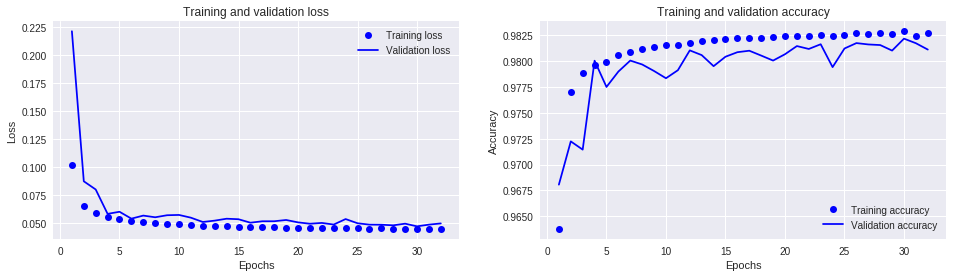

In [12]:
plot_history(history)

In [13]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 9s 273us/step
([0.04840301671897788, 0.9817431616424561], 0.9862876614819941)
